# FOOOF - Tutorial

<div class="alert alert-success">
FOOOF (fitting oscillations & one over f) is a module to fit neural power spectra. This tutorial covers the fundamentals of the FOOOF codebase. 
</div>

<div class="alert alert-info">
For a theoretical description of the model, go [here](01-ModelDescription.ipynb), or for a more  detailed guide through the algorithm, in code, go [here](Internals.ipynb)
</div>

In [1]:
# General imports
%matplotlib inline
import numpy as np

In [2]:
# Import the FOOOF object
from fooof import FOOOF

In [3]:
# Load example data to use for this tutorial (a single example PSD)
freqs = np.load('dat/freqs.npy')
psd = np.load('dat/psd.npy')

## FOOOF Object

Fooof, as a module, is object oriented. At it's core, this is the FOOOF object, which holds relevant data and settings as attributes, and procedures to run the FOOOF algorithm as methods. 

It's organization is similar to scikit-learn, whereby a model object is initialize with relevant settings, then the model is fit, after which relevant results can be extracted from the object.

In [4]:
# Check the docs for the FOOOF object
FOOOF?

### FOOOF.model( ) vs. FOOOF.fit()

There are 2 main ways to fit the PSD model with FOOOF.

Each method calls the same underlying fitting procedure, the only difference being what is printed out to the console.

- FOOOF.model( ) fits the PSD model, then plots the PSD & model, and prints out the model parameters. 
- FOOOF.fit( ) just fits the model. 

The model fit parameters are stored as object attributes that can be accessed after fitting.

## FOOOF Example


FOOOF WARNING: Lower-bound bandwidth limit is < or ~= the frequency resolution: 0.49 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is freq-res)
	Too low a limit may lead to overfitting noise as small bandwidth oscillations.
	We recommend a lower bound of approximately 2x the frequency resolution.


                                          FOOOF - PSD MODEL                                         

                    The input PSD was modelled in the frequency range: 2 - 40 Hz                    
                                  Frequency Resolution is 0.49 Hz                                   

                              Background Parameters (offset, slope):                                
                                          -21.8968, 0.7635                                          

                                     4 oscillations were found:                                     
                                 CF:   9.75, Amp:

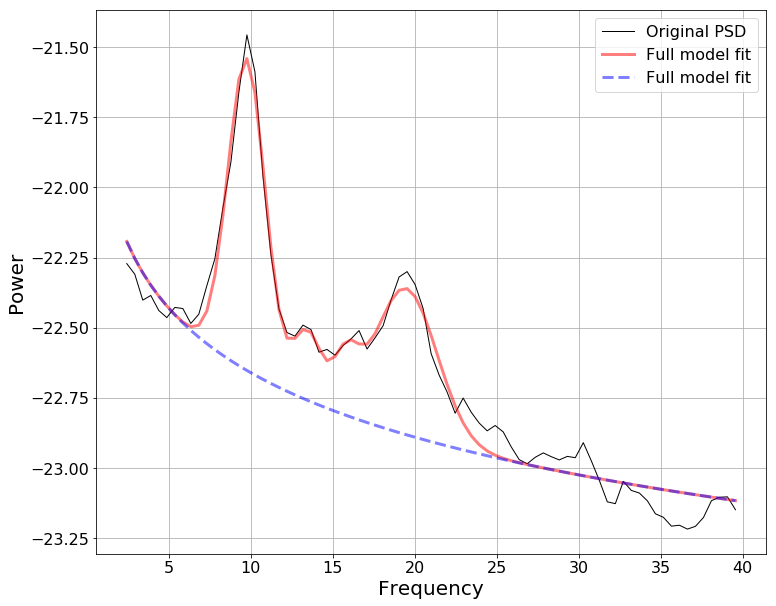

In [5]:
# Initialize FOOOF model
fm = FOOOF()

# Set the frequency range upon which to fit FOOOF
freq_range = [2, 40]

# Run FOOOF model - calculates model, plots, and prints parameters
#  Calling model necessarily requires providing the frequency vector, psd data, and frequency range to fit
#  You can also (optionally) specify whether to plot the result in log-log space (defaults to False: semi-log space)
fm.model(freqs, psd, freq_range)

In [6]:
# Alternatively, just fit the model with FOOOF.fit()
fm.fit(freqs, psd, freq_range)

# After fitting (with .model() or .fit()), plotting and parameter fitting can be called independently:
# fm.plot()
# fm.print_params()


FOOOF WARNING: Lower-bound bandwidth limit is < or ~= the frequency resolution: 0.49 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is freq-res)
	Too low a limit may lead to overfitting noise as small bandwidth oscillations.
	We recommend a lower bound of approximately 2x the frequency resolution.



### FOOOF Results

In [7]:
# Background params 
print('Background Parameters: \n', fm.background_params_, '\n')

# Oscillation parameters
print('Oscillation Parameters: \n', fm.oscillation_params_, '\n')

Background Parameters: 
 [-21.89682937   0.76346864] 

Oscillation Parameters: 
 [[  9.74716521   1.11125396   2.28154043]
 [ 13.46025653   0.24785595   1.68052342]
 [ 15.81191698   0.24964902   1.55741871]
 [ 19.48856681   0.52143303   3.7670429 ]] 



### Notes on Interpreting Oscillation Parameters

Note that the oscillation parameters that are returned are not exactly the same as the parameters of the gaussians used internally to fit the oscillations. 

Specifically:
- CF is the mean parameter of the gaussian
- Amp is the amplitude of the model fit above the background slope fit [1]
- BW is 2 * the standard deviation of the gaussian [2]

[1] Since the gaussians are fit together, the amplitude of the gaussians can only be interpreted with respect to all other oscillations, making gaussian amplitude uninterpretable in isolation.

[2] Standard deviation is '1 sided', returned BW is '2 sided'.

In [8]:
# There is also convenience method to gather model results 
bg_params, osc_params, r_squared, fit_error, gauss_params = fm.get_results()

In [9]:
# Get results actually returns a FOOOFResult object (a named tuple)
fres = fm.get_results()

In [10]:
# Print out the FOOOFResults
print(fres, '\n')

# From FOOOFResults, you can access the different results
print('Background Params: \n', fres.background_params)

FOOOFResult(background_params=array([-21.89682937,   0.76346864]), oscillation_params=array([[  9.74716521,   1.11125396,   2.28154043],
       [ 13.46025653,   0.24785595,   1.68052342],
       [ 15.81191698,   0.24964902,   1.55741871],
       [ 19.48856681,   0.52143303,   3.7670429 ]]), r2=0.97817106770520845, error=0.048035359396278961, gaussian_params=array([[  9.74716521,   1.11138316,   1.14077022],
       [ 13.46025653,   0.24387152,   0.84026171],
       [ 15.81191698,   0.1823705 ,   0.77870936],
       [ 19.48856681,   0.52156491,   1.88352145]])) 

Background Params: 
 [-21.89682937   0.76346864]


In [11]:
# Check the r^2 and error of the model fit
print('R-squared: \n', fm.r2_)
print('Fit error: \n', fm.error_)

R-squared: 
 0.978171067705
Fit error: 
 0.0480353593963


### Description of FOOOF methods and parameters

FOOOF follows the Python convention in which all user exposed settings, data, and methods are directly accessible through the object, where as 'hidden' ones have a leading underscore.

The FOOOF object contents consist of 4 main components:
- Settings (attributes)
    - User exposed settings are all set in object initialization. 
    - There are some internal settings that are not exposed at initialization. These settings are unlikely to need to be accessed by the user, but can be if desired - they are  all defined and documented in init, there should be no other settings, or 'magic numbers' in any other parts of the code.
- Data (attributes)
    - FOOOF stores the frequency vector, power spectrum, frequency range, and frequency resolution.
        - fm.freqs, fm.psd, fm.freq_range, fm.freq_res
    - During the fit procedure, interim data variable are created and used. underscore. 
- Results (attributes)
    - FOOOF follows the scipy convention in that any attributes that are result from fitting to the data are indicated by a trailing underscore
        - fm.background\_params_, fm.oscillation\_params\_, fm.psd\_fit\_, fm.r2\_, fm.error\_
- Functions (methods)
    - Functions that operate on the FOOOF object data.
    - In addition to the exposed methods, there are some internal methods called in the fitting procedure. These methods should not be called independently, as they may depend on internal state as defined from other methods. 

In [12]:
# You can check all the user defined FOOOF settings with check_settings
#  The description parameter prints out a full description. A shorter summary is printed when False. 
fm.print_settings(description=True)


                                          FOOOF - SETTINGS                                          

                                          Fit Knee : False                                          
                       Whether to fit a knee parameter in background fitting.                       
                                   Bandwidth Limits : (0.5, 12.0)                                   
                  Possible range of bandwidths for extracted oscillations, in Hz.                   
                                  Max Number of Oscillations : inf                                  
                     The maximum number of oscillations that can be extracted.                      
                                      Minimum Amplitude : 0.0                                       
         Minimum absolute amplitude, above background, for an oscillation to be extracted.          
                                      Amplitude Threshold: 2.0                           

### Fitting FOOOF, with different settings

In [13]:
# Load example data - a different PSD
freqs = np.load('dat/freqs_2.npy')
psd = np.load('dat/psd_2.npy')


                                          FOOOF - PSD MODEL                                         

                    The input PSD was modelled in the frequency range: 2 - 40 Hz                    
                                  Frequency Resolution is 0.49 Hz                                   

                              Background Parameters (offset, slope):                                
                                          -21.4437, 1.0751                                          

                                     3 oscillations were found:                                     
                                 CF:   9.82, Amp:  0.728, BW:  3.00                                 
                                 CF:  13.04, Amp:  0.260, BW:  2.54                                 
                                 CF:  18.13, Amp:  0.151, BW:  4.63                                 

                                     R^2 of model fit is 0.9923                       

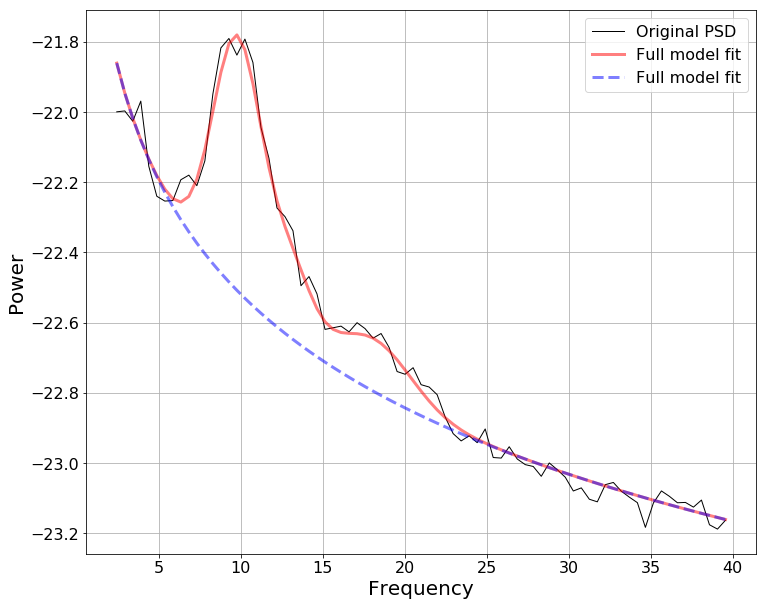

In [14]:
# Initialize FOOOF model, with different settings
fm = FOOOF(bandwidth_limits=(1, 8), max_n_oscs=6 , min_amp=0.15)

# Fit FOOOF
f_range = [2, 40]
fm.model(freqs, psd, f_range)

### Updating Settings

If you wish to change these settings, re-initialize the FOOOF object with new settings. Simply resetting the relevant attribute may not appropriately propragate the value, and may fail (either by erroring out, or not applying the settings properly during fit and returning erroneous results). 

### Fitting FOOOF, with background knee

In [15]:
# Load example data (LFP)
freqs = np.load('dat/freqs_lfp.npy')
psd = np.load('dat/psd_lfp.npy')


                                          FOOOF - PSD MODEL                                         

                    The input PSD was modelled in the frequency range: 2 - 60 Hz                    
                                  Frequency Resolution is 1.00 Hz                                   

                           Background Parameters (offset, knee, slope):                             
                                      6.3562, 47.5550, 1.8879                                       

                                     2 oscillations were found:                                     
                                 CF:   7.99, Amp:  0.822, BW:  2.06                                 
                                 CF:  16.29, Amp:  0.246, BW:  2.37                                 

                                     R^2 of model fit is 0.9935                                     
                           Root mean squared error of model fit is 0.0370             

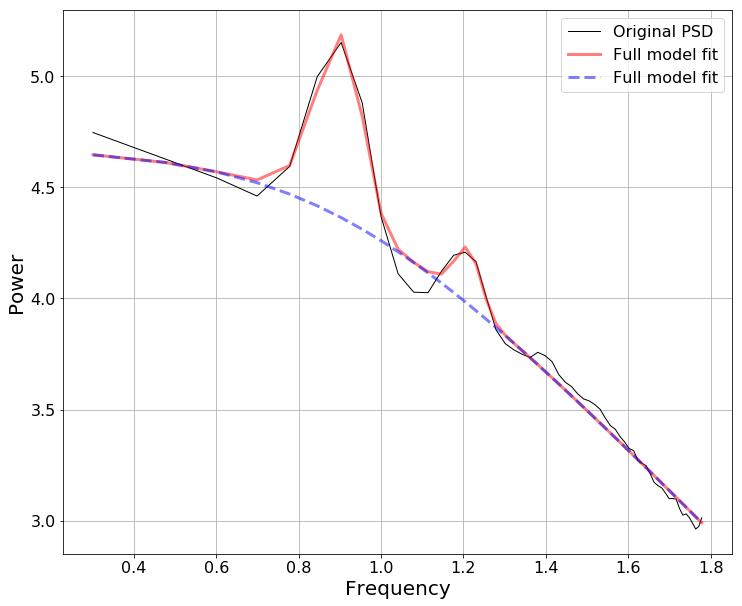

In [16]:
# Initialize FOOOF - setting to fit a knee
fm = FOOOF(bandwidth_limits=(2, 8), bg_use_knee=True)

# Fit FOOOF model
fm.model(freqs, psd, [2, 60], plt_log=True)

## FOOOF - Saving & Reports

In [17]:
# Saving FOOOF results, settings, and data
fm.save(save_results=True, save_settings=True, save_data=True)

In [18]:
# Loading FOOOF results
nfm = FOOOF()
nfm.load()

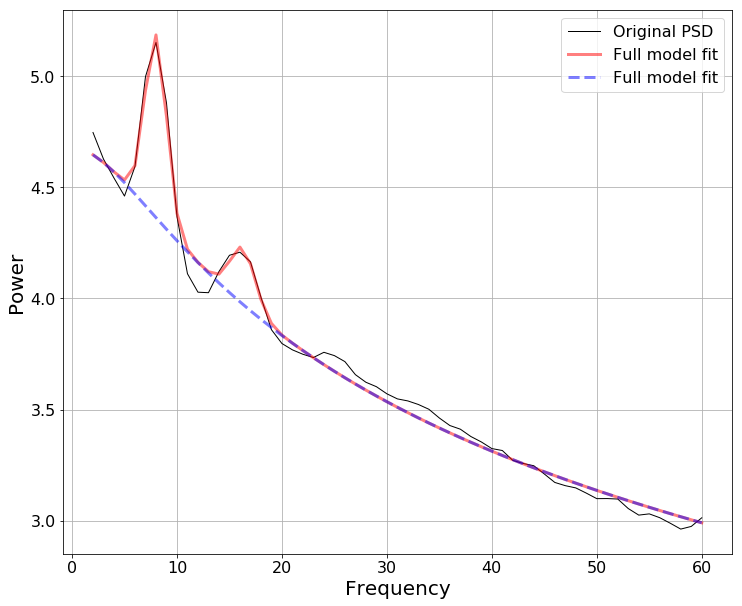

In [19]:
# Plot loaded results
nfm.plot()

### Create a Report

FOOOF also has functionality to save out a 'report' of a particular PSD fit.

This generates a PDF which contains the same output as 'print_results', 'plot', and 'print_settings'. 

In [20]:
# Create a report
#  Which no arguments, this will use the default name ('FOOOF_Report'), and save to current directory
#    Add inputs to the method call to specify a file-name, and save-location
fm.create_report()

In [21]:
# Check what the generated report looks like
from IPython.display import IFrame
IFrame("FOOOF_Report.pdf", width=950, height=1200)